In [1]:
import tensorflow as tf
import numpy as np

import os
import pathlib
import time
import datetime
import h5py

from matplotlib import pyplot as plt
from IPython import display

In [2]:
print(tf.__version__)
print("GPU available:", len(tf.config.list_physical_devices('GPU')))

tf.config.run_functions_eagerly(True)

2.4.1
GPU available: 8


In [3]:
f = h5py.File("/raid/shumnov/hypersim/dataset/ai_001_010.hdf5", "r")

color = f["color"][()]
albedo = f["diffuse_reflectance"][()]
depth = f["depth_meters"][()]
normals = f["normal_bump_cam"][()]

f.close()

327


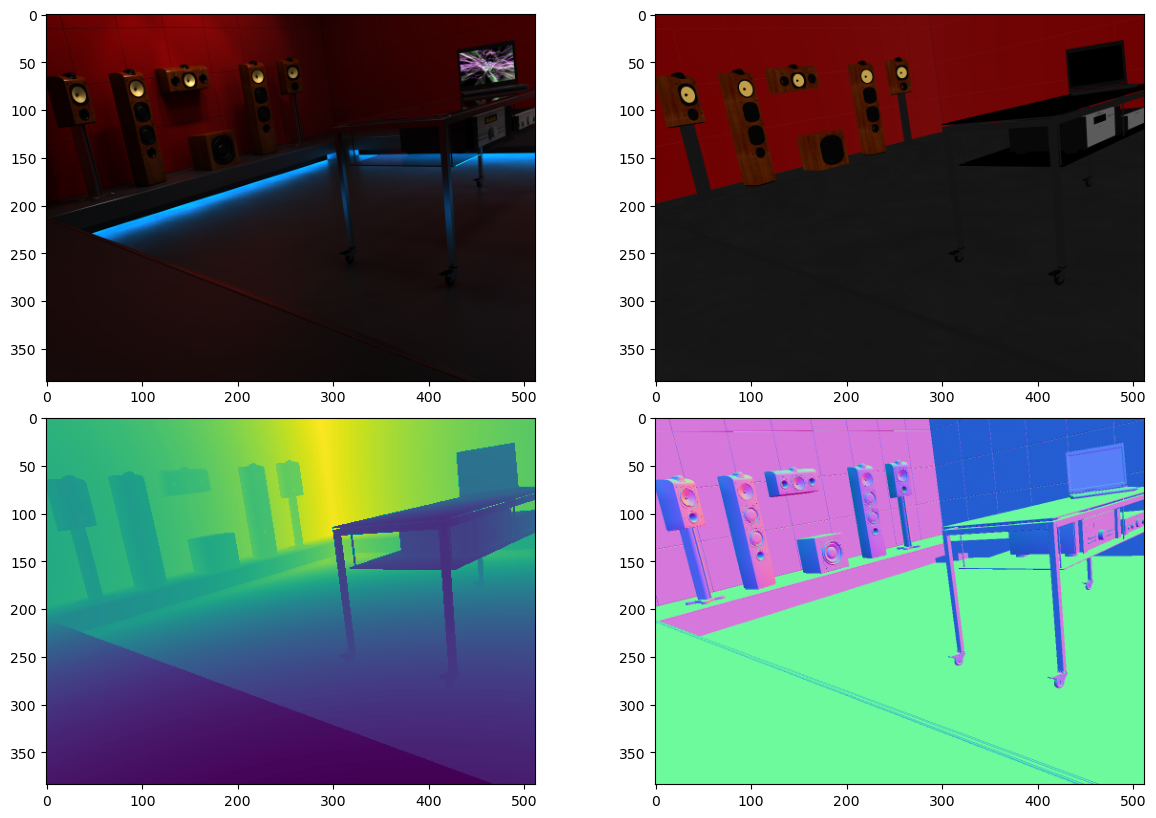

In [4]:
def show_channels(index):
    f, plots = plt.subplots(2, 2, figsize=(15, 10))
    
    plots[0][0].imshow((color[index] + 1) / 2)
    plots[0][1].imshow((albedo[index] + 1) / 2)
    plots[1][0].imshow(np.squeeze(depth[index]))
    plots[1][1].imshow((normals[index] + 1) / 2)
    
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

def show_data(index, x, y):
    f, plots = plt.subplots(2, 2, figsize=(15, 15))
    
    plots[0][0].imshow((y[index] + 1) / 2)
    plots[0][1].imshow((x[index][..., 0:3] + 1) / 2)
    plots[1][0].imshow(np.squeeze(x[index][..., 3]))
    plots[1][1].imshow((x[index][..., 4:7] + 1) / 2)
    
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

print(len(color))
show_channels(48)

In [5]:
x = np.concatenate((albedo, depth, normals), axis=3)
y = color
# color, albedo, depth, normals = None, None, None, None

# x = np.resize(x, (x.shape[0], 512, 512, x.shape[3]))
# y = np.resize(y, (y.shape[0], 512, 512, y.shape[3]))

x = np.pad(x, ((0, 0), (64, 64), (0, 0), (0, 0)), mode='constant', constant_values=(0, 0))
y = np.pad(y, ((0, 0), (64, 64), (0, 0), (0, 0)), mode='constant', constant_values=(0, 0))

x = np.concatenate((x, np.flip(x, axis=2)), axis=0)
y = np.concatenate((y, np.flip(y, axis=2)), axis=0)

x = x.astype(np.float32)
y = y.astype(np.float32)

In [7]:
BUFFER_SIZE = 256
BATCH_SIZE = 1

In [8]:
'''
train_dataset = tf.data.Dataset.from_tensor_slices((x[:BUFFER_SIZE - 2], y[:BUFFER_SIZE - 2]))
train_dataset.shuffle(BUFFER_SIZE)
train_dataset.batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices((x[-2:], y[-2:]))
test_dataset.shuffle(BUFFER_SIZE)
test_dataset.batch(BATCH_SIZE)
'''

'\ntrain_dataset = tf.data.Dataset.from_tensor_slices((x[:BUFFER_SIZE - 2], y[:BUFFER_SIZE - 2]))\ntrain_dataset.shuffle(BUFFER_SIZE)\ntrain_dataset.batch(BATCH_SIZE)\n\ntest_dataset = tf.data.Dataset.from_tensor_slices((x[-2:], y[-2:]))\ntest_dataset.shuffle(BUFFER_SIZE)\ntest_dataset.batch(BATCH_SIZE)\n'

# Generator

In [9]:
WIDTH = 512
HEIGHT = 512
INPUT_CHANNELS = 7
OUTPUT_CHANNELS = 3

##  Downsampler (encoder)
### Convolution -> Batch normalization -> Leaky ReLU
### Convolution:
- **filters**: integer, the dimensionality of the output space (i.e. the number of output filters in the convolution)
- **kernel_size**: an integer or tuple/list of 2 integers, specifying the height and width of the 2D convolution window
- **strides**: an integer or tuple/list of 2 integers, specifying the strides (шаги) of the convolution along the height and width
- **padding**: "valid" means no padding; "same" results in padding with zeros evenly to the left/right or up/down of the input such that output has the same height/width dimension as the input
- **kernel_initializer**: initializer for the kernel weights matrix
- **use_bias**: boolean, whether the layer uses a bias vector

In [10]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2D(filters, kernel_size=size, strides=2, padding='same',
                                kernel_initializer=initializer, use_bias=False))
    
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

In [11]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(x[0], 0))
print(tf.expand_dims(x[0], 0).shape)
print(down_result.shape)

(1, 512, 512, 7)
(1, 256, 256, 3)


##  Upsampler (decoder)
### Transposed convolution -> Batch normalization -> Dropout (applied to the first 3 blocks) -> ReLU


In [12]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

In [13]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print(down_result.shape)
print (up_result.shape)

(1, 256, 256, 3)
(1, 512, 512, 3)


##  Generator
### Downsampler + upsampler + skip connections

In [14]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[WIDTH, HEIGHT, INPUT_CHANNELS])

    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (batch_size, 256, 256, 64)
        downsample(128, 4),  # (batch_size, 128, 128, 128)
        downsample(256, 4),  # (batch_size, 64, 64, 256)
        downsample(512, 4),  # (batch_size, 32, 32, 512)
        downsample(512, 4),  # (batch_size, 16, 16, 512)
        downsample(512, 4),  # (batch_size, 8, 8, 512)
        downsample(512, 4),  # (batch_size, 4, 4, 512)
        downsample(512, 4),  # (batch_size, 2, 2, 512)
        downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
        upsample(512, 4),  # (batch_size, 16, 16, 1024)
        upsample(512, 4),  # (batch_size, 32, 32, 1024)
        upsample(256, 4),  # (batch_size, 64, 64, 512)
        upsample(128, 4),  # (batch_size, 128, 128, 256)
        upsample(64, 4),  # (batch_size, 256, 256, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 512, 512, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

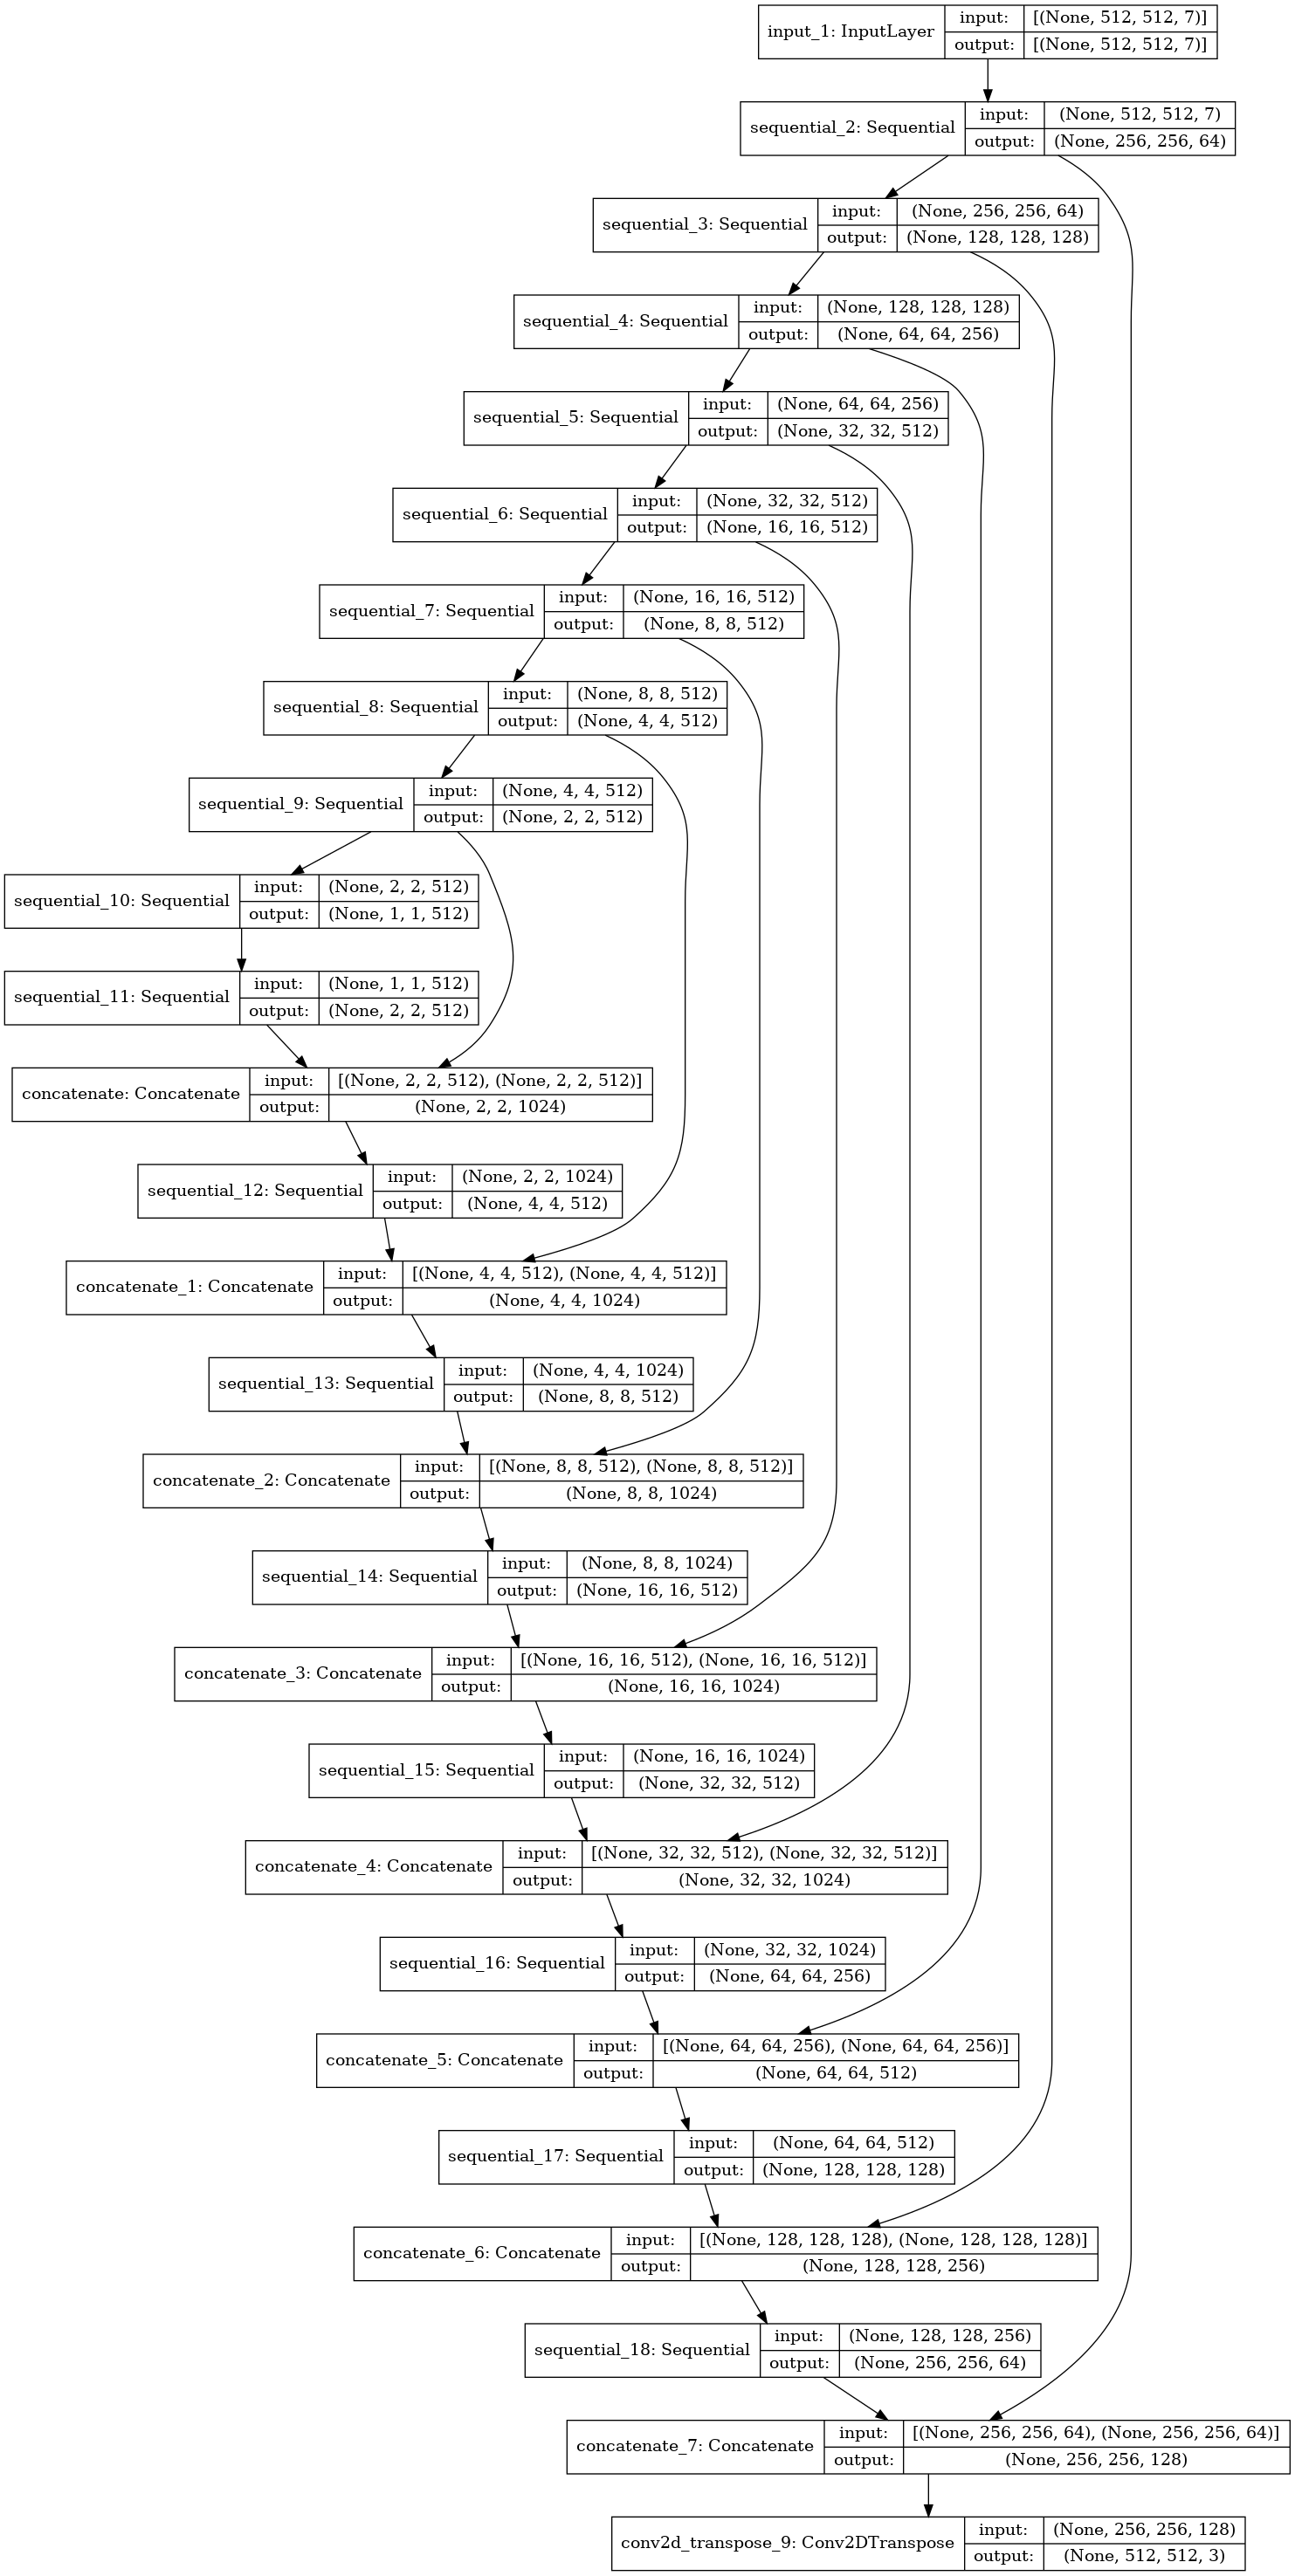

In [15]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True) #, dpi=64)

In [16]:
gen_output = generator(x[10][tf.newaxis, ...], training=False)

plt.imshow((gen_output[0, ...] + 1) / 2)

In [17]:
LAMBDA = 100

loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [18]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # Mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

# Discriminator

## PatchGAN
### Each block: Convolution -> Batch normalization -> Leaky ReLU

In [19]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[512, 512, 7], name='input_image')
    tar = tf.keras.layers.Input(shape=[512, 512, 3], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

    down1 = downsample(64, 4, False)(x)  # (batch_size, 256, 256, 64)
    down2 = downsample(128, 4)(down1)  # (batch_size, 128, 128, 128)
    down3 = downsample(256, 4)(down2)  # (batch_size, 64, 64, 256)
    down4 = downsample(512, 4)(down3)  # (batch_size, 32, 32, 512)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down4)  # (batch_size, 34, 34, 512)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)

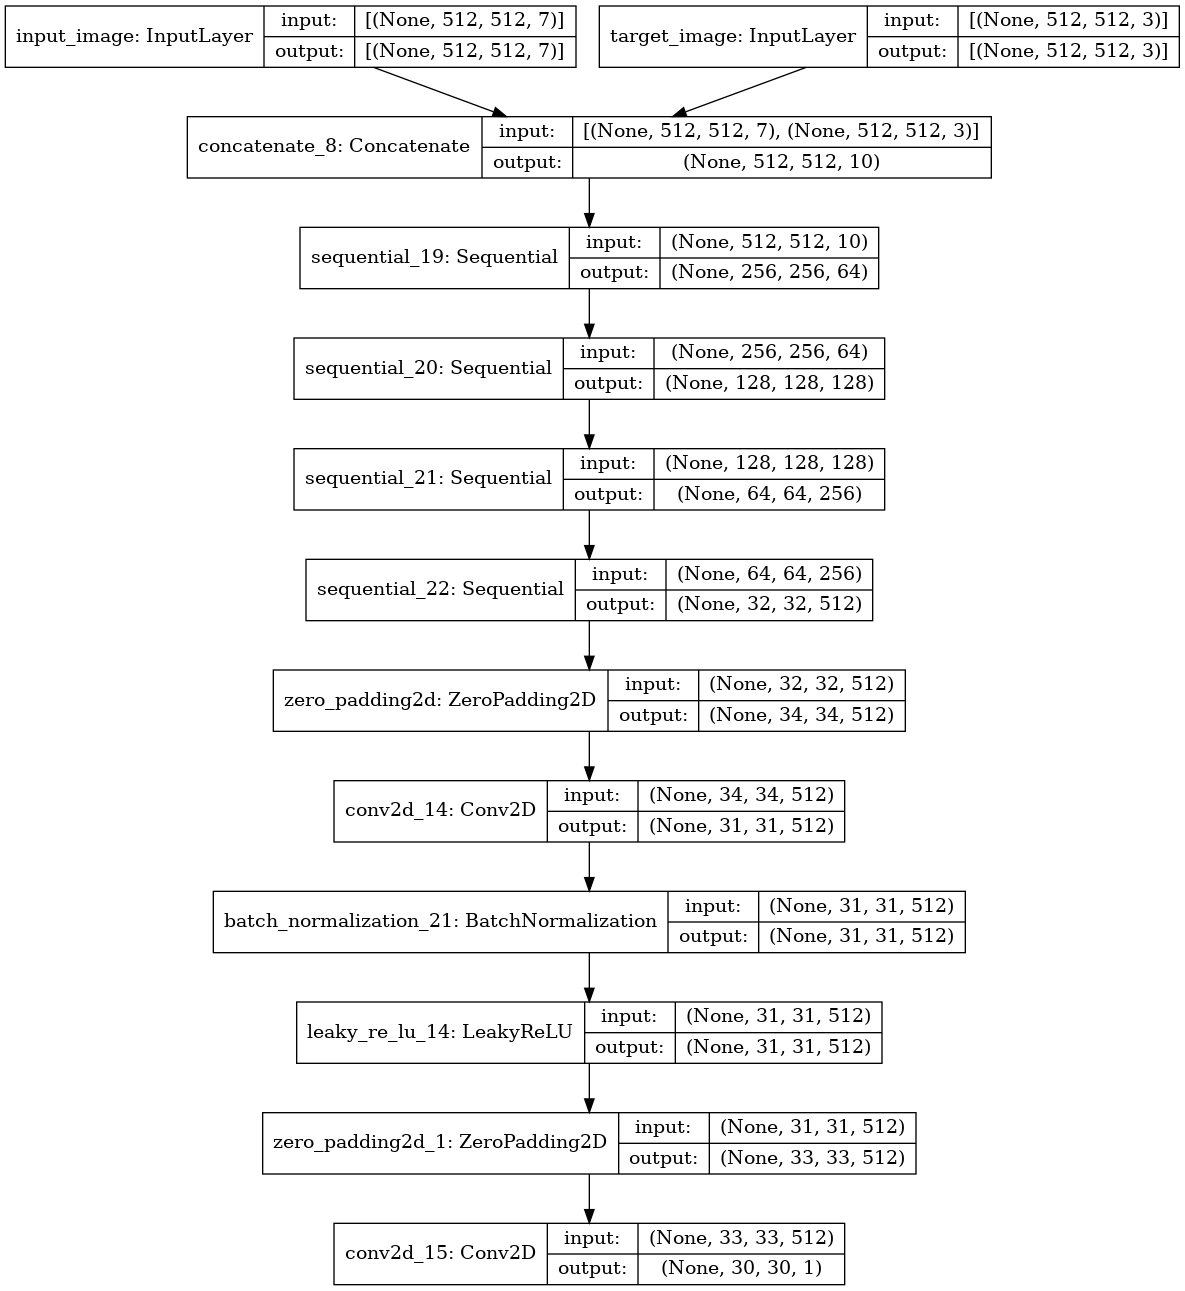

In [20]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True)

In [21]:
print(x[10][tf.newaxis, ...].shape, gen_output.shape)

disc_out = Discriminator()([x[10][tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20e-2, vmax=20e-2, cmap='RdBu_r')
plt.colorbar()
plt.show()

(1, 512, 512, 7) (1, 512, 512, 3)


In [22]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

In [23]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [24]:
checkpoint_dir = '/raid/shumnov/deep-render/checkpoints/'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [25]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']
    
    fig, axs = plt.subplots(1, 3)
    fig.set_size_inches(20, 20)

    for i in range(3):
        img = display_list[i][..., :3]
        axs[i].set_title(title[i])
        axs[i].imshow(img * 0.5 + 0.5)
        axs[i].axis('off')
    
    plt.show()

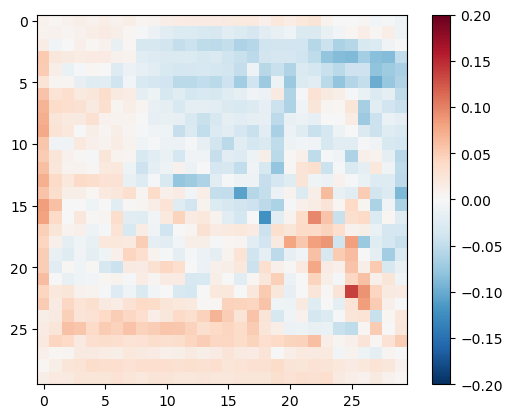

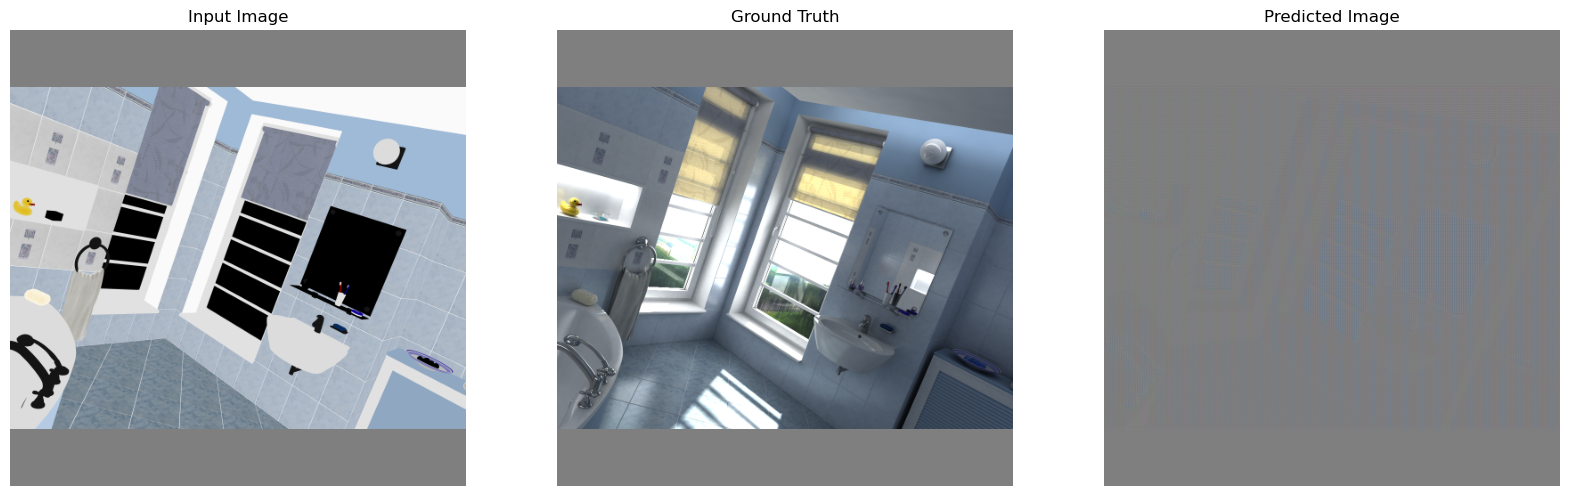

In [26]:
generate_images(generator, np.expand_dims(x[0], 0), np.expand_dims(y[0], 0))

In [27]:
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
    log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [28]:
@tf.function
def train_step(input_image, target, step):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
        tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
        tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

In [29]:
def fit(train_x, train_y, test_x, test_y, steps):
    example_input, example_target = test_x[0], test_y[0]
    train_len = len(train_x)
    start = time.time()

    for step in range(steps):
        if (step) % 1000 == 0:
            display.clear_output(wait=True)

            if step != 0:
                print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

            start = time.time()

            generate_images(generator, example_input, example_target)
            
            print(f"Step: {step//1000}k")

        train_step(train_x[step % train_len], train_y[step % train_len], step)

        # Training step
        if (step+1) % 10 == 0:
            print('.', end='', flush=True)


        # Save (checkpoint) the model every 5k steps
        if (step + 1) % 5000 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

Time taken for 1000 steps: 134.70 sec



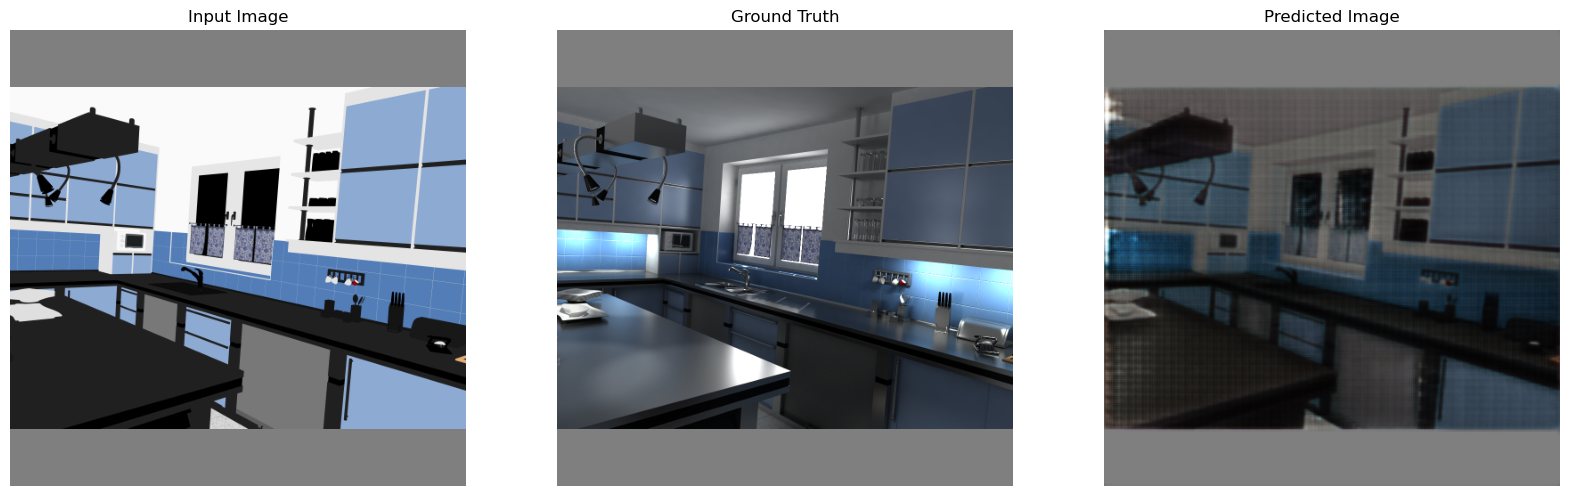

Step: 4k
....................................................................................................

In [30]:
x1 = np.expand_dims(x, 1)
y1 = np.expand_dims(y, 1)

fit(x1[:-3], y1[:-3], x1[-3:-2], y1[-3:-2], steps=5000)

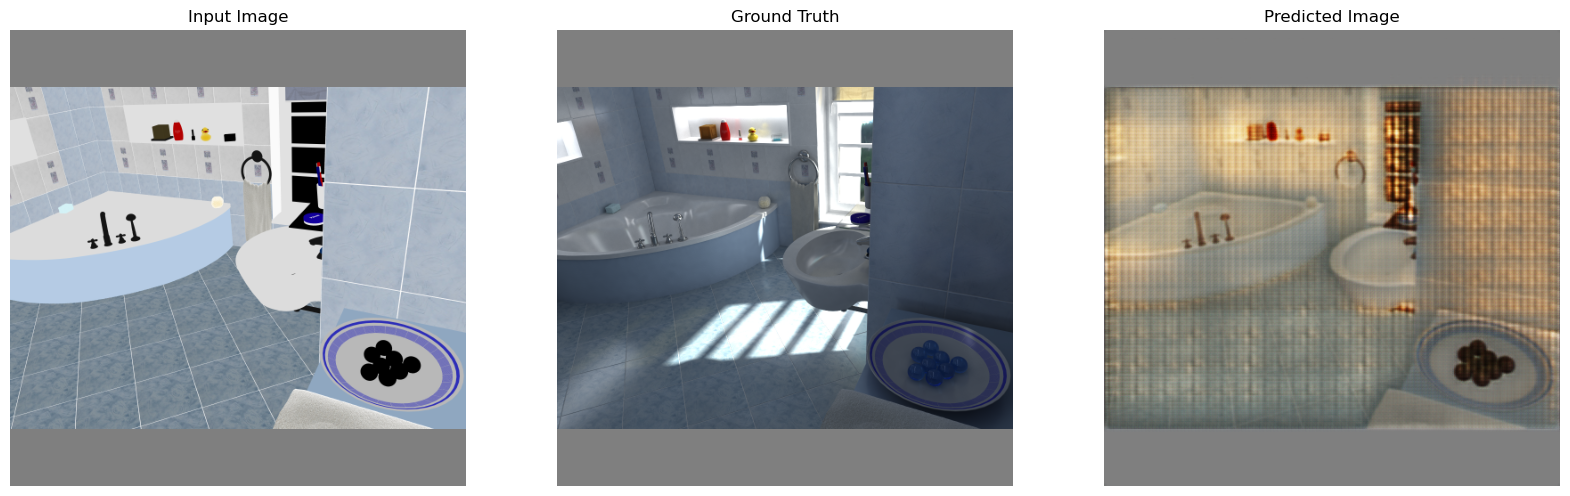

In [37]:
generate_images(generator, x1[15], y1[15])